# Анализ пользовательского поведения в мобильном приложении

## Введение

Для нашего мобильного приложения дизайнеры решили изменить шрифт. Но для начала мы решили провести тест с двумя контрольными группами. Две контрольные группы помогут нам выполнить тест более точно. Так же, мы рассмотрим воронки продаж и выявим на каком этапе мы теряем больше всего клиентов.

## Изучение данных

Импортируем необходимые библиотеки и откроем предоставленный файл.

In [ ]:
#импорт библиотек, форматирование
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
from plotly import graph_objects as go
import re 
import math as mth

pd.options.display.float_format = '{:,.1f}'.format

import plotly.io as pio
pio.renderers.default = "png"

In [ ]:
#чтение csv файла
df = pd.read_csv('/datasets/logs_exp.csv',  sep='\t')

#вывод первых 5 строк датафрейма
df.head(5) 

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Итак, наша таблица состоит из следующих столбцов:
<br>`EventName` — название события;
<br>`DeviceIDHash` — уникальный идентификатор пользователя;
<br>`EventTimestamp` — время события;
<br>`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
<br>Рассмотрим, сколько уникальных значений в столбце `EventName`, что бы избежать дублей

In [ ]:
df['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

У нас получилось 5 уникальных значений, дублей нет.
<br> Так же проверим столбец `ExpId`, в нем должно быть три уникальных значения. 

In [ ]:
df['ExpId'].unique()

array([246, 248, 247])

Так и вышло, у нас три уникальных значения.
<br> Посмотрим общую информацию о датафрейме

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Можно отметить, что пропущенных значений в датафрейме нет.
<br> Всего у нас 244 126 строк. Первый столбец имеет тип данных *object*, а остальные *int64*

## Подготовка данных

Переименнуем столбцы, что бы в дальнейшем с ними было удобнее работать.

In [ ]:
#переименование столбцов
df = df.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'})

#вывод первых 3 строк датафрейма
df.head(3) 

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


Добавим новый столбец, в котором будет информаци я о дате и времени, т.к. в столбце `event_timestamp` дата зашифрована.

In [ ]:
#создание столбца с датой и временем
df['date_time'] = pd.to_datetime(df['event_timestamp'], unit='s')

df

,event_name,user_id,event_timestamp,exp_id,date_time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58


Так же создадим отдельный столбец с датой без времени.

In [ ]:
#создание столбца с датой
df["event_date"] = df["date_time"].dt.date

df

,event_name,user_id,event_timestamp,exp_id,date_time,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


Изменим данные столбца `exp_id` для удобства. Заменим название групп **246** на **А1**,  **247** на **А2** и **248** на **В** с помощью функции.

In [ ]:
def test_group(i):
    if i==246:
        return 'A1'
    elif i==247:
        return 'A2'
    elif i==248:
        return 'B'
    else:
        return 'UnknownGroup'

df['exp_id'] = df['exp_id'].apply(test_group)
df

,event_name,user_id,event_timestamp,exp_id,date_time,event_date
0,MainScreenAppear,4575588528974610257,1564029816,A1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,A1,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,A2,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,A1,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,A1,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,A1,2019-08-07 21:14:58,2019-08-07


Проверим есть ли явные дубликаты в данных.

In [ ]:
df.duplicated().sum()

413

In [ ]:
df[df.duplicated()].head(30)

,event_name,user_id,event_timestamp,exp_id,date_time,event_date
453,MainScreenAppear,5613408041324010552,1564474784,B,2019-07-30 08:19:44,2019-07-30
2350,CartScreenAppear,1694940645335807244,1564609899,B,2019-07-31 21:51:39,2019-07-31
3573,MainScreenAppear,434103746454591587,1564628377,B,2019-08-01 02:59:37,2019-08-01
4076,MainScreenAppear,3761373764179762633,1564631266,A2,2019-08-01 03:47:46,2019-08-01
4803,MainScreenAppear,2835328739789306622,1564634641,B,2019-08-01 04:44:01,2019-08-01
5641,CartScreenAppear,4248762472840564256,1564637764,B,2019-08-01 05:36:04,2019-08-01
5875,PaymentScreenSuccessful,6427012997733591237,1564638452,B,2019-08-01 05:47:32,2019-08-01
7249,OffersScreenAppear,7224691986599895551,1564641846,A1,2019-08-01 06:44:06,2019-08-01
8065,CartScreenAppear,8189122927585332969,1564643929,B,2019-08-01 07:18:49,2019-08-01
9179,MainScreenAppear,2230705996155527339,1564646087,A1,2019-08-01 07:54:47,2019-08-01


Дубликатов оказалось *413*.  Чаще всего  дубликаты возникают по двум причинам: человеческий фактор и техническая ошибка. В данном случае возможны оба варианта. Например, строки, которые дублируются подряд, скорее всего возникли из-за повторно отправленной информации о перехоже на ту или иную страницу приложения.
<br>Удалим дубликаты.

In [ ]:
#удаление дубликатов
df = df.drop_duplicates().reset_index()

##  Проверка данных

Как мы помним уникальный событий в логe 5. Перечислим их:
<br>`MainScreenAppear` - Открытие главной страницы,
<br>`OffersScreenAppear`  - Открытие страницы с товарами,
<br>`CartScreenAppear` - Открытие страницы корзины,
<br>`PaymentScreenSuccessful` - Страница успешного платежа, 
<br>`Tutorial` - Руководство.
<br>Вcего событий 243 713
<br>Найдем количество уникальных пользователей

In [ ]:
#подсчет уникальных id пользователей
uniq_user = df['user_id'].nunique()
uniq_user

7551

Рассмотрим, сколько действий в среднем приходится на каждого пользователя.

In [ ]:
#подсчет среднего числа действий на каждого пользователя
mean_mov = round(df['user_id'].count() / uniq_user, 1)
mean_mov

32.3

*32,3* действия в среднем приходится на одного пользователя.
<br> Посмотрим за какой период времени у нас есть данные.

In [ ]:
first_day = df['event_date'].min()
last_day = df['event_date'].max()
cont_day = df['event_date'].max() - df['event_date'].min()
print(f'Мы распологаем данными с', first_day, ' по ', last_day)
print(f'Всего дней для рассмотрения у нас ', last_day - first_day, 'sec.')


Мы распологаем данными с 2019-07-25  по  2019-08-07
Всего дней для рассмотрения у нас  13 days, 0:00:00 sec.


Построим гистограмму и посмотрим распределение данных во времени.

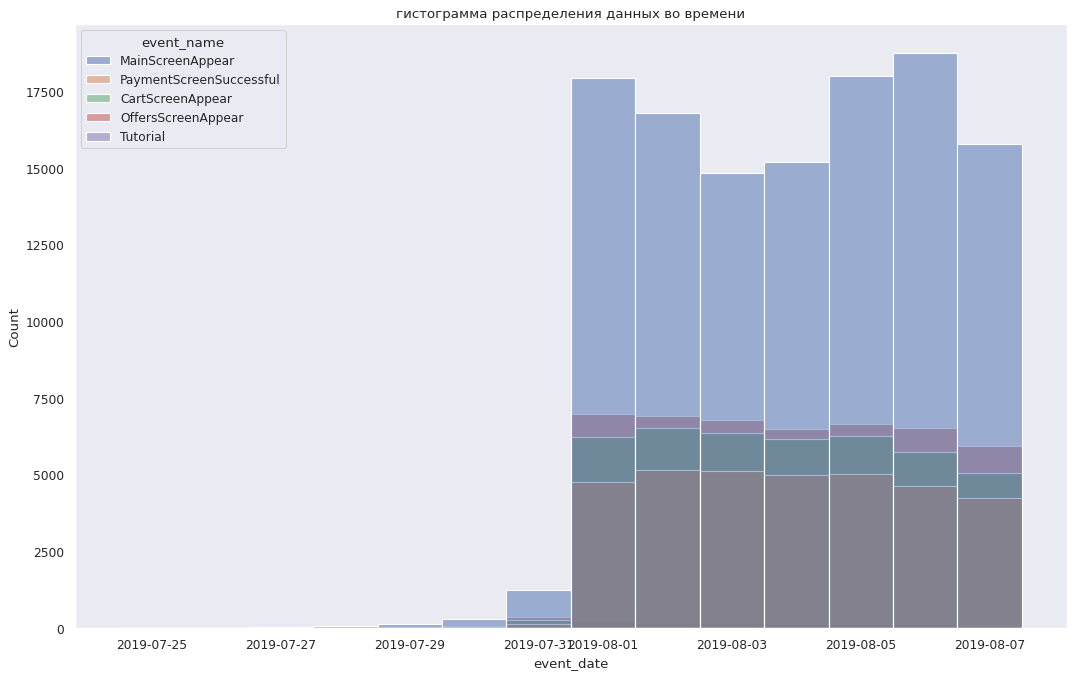

In [ ]:
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.set() 
sns.histplot(data=df, x="event_date", binwidth=0.05, hue="event_name")
plt.title('гистограмма распределения данных во времени')
plt.grid([])
plt.show()

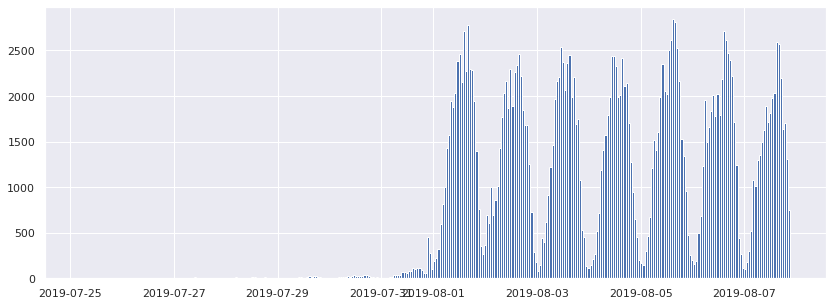

In [ ]:
# код ревьюера
df['date_time'].hist(bins=14*24, figsize=(14, 5));

На гистограмме видно, что данных значительно меньше до 31.07.19 включительно. Посмотрим сколько это строк.

In [ ]:
#срез данных до 31.07.19
not_date = df.loc[df['date_time'] <'2019-08-01 00:00:00']
not_date

,index,event_name,user_id,event_timestamp,exp_id,date_time,event_date
0,0,MainScreenAppear,4575588528974610257,1564029816,A1,2019-07-25 04:43:36,2019-07-25
1,1,MainScreenAppear,7416695313311560658,1564053102,A1,2019-07-25 11:11:42,2019-07-25
2,2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
3,3,CartScreenAppear,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
4,4,PaymentScreenSuccessful,6217807653094995999,1564055322,B,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...,...
2821,2823,OffersScreenAppear,2413191300976302222,1564617295,A2,2019-07-31 23:54:55,2019-07-31
2822,2824,MainScreenAppear,5505110279185484837,1564617450,A2,2019-07-31 23:57:30,2019-07-31
2823,2825,MainScreenAppear,5505110279185484837,1564617462,A2,2019-07-31 23:57:42,2019-07-31
2824,2826,MainScreenAppear,5505110279185484837,1564617472,A2,2019-07-31 23:57:52,2019-07-31


In [ ]:
#Подсчет процента данных до 31.07.19
print(f'Процент данных собранных до 01.08.2019 - {round((not_date.shape[0]*100/df.shape[0]),2)}%')

Процент данных собранных до 01.08.2019 - 1.16%


Данные до 01.08.19 мы можем исключить. По сравнению с количеством данных с 01.08.19 более ранее данные  очень малы и не полны, но способны исказить наше исследование, поэтому удалим их

In [ ]:
#обрезка данных
df = df.loc[df['date_time'] >'2019-07-31 23:59:59']
df

,index,event_name,user_id,event_timestamp,exp_id,date_time,event_date
2826,2828,Tutorial,3737462046622621720,1564618048,A1,2019-08-01 00:07:28,2019-08-01
2827,2829,MainScreenAppear,3737462046622621720,1564618080,A1,2019-08-01 00:08:00,2019-08-01
2828,2830,MainScreenAppear,3737462046622621720,1564618135,A1,2019-08-01 00:08:55,2019-08-01
2829,2831,OffersScreenAppear,3737462046622621720,1564618138,A1,2019-08-01 00:08:58,2019-08-01
2830,2832,MainScreenAppear,1433840883824088890,1564618139,A2,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...,...
243708,244121,MainScreenAppear,4599628364049201812,1565212345,A2,2019-08-07 21:12:25,2019-08-07
243709,244122,MainScreenAppear,5849806612437486590,1565212439,A1,2019-08-07 21:13:59,2019-08-07
243710,244123,MainScreenAppear,5746969938801999050,1565212483,A1,2019-08-07 21:14:43,2019-08-07
243711,244124,MainScreenAppear,5746969938801999050,1565212498,A1,2019-08-07 21:14:58,2019-08-07


ПОсмотрим гистограмму после удаление данных.

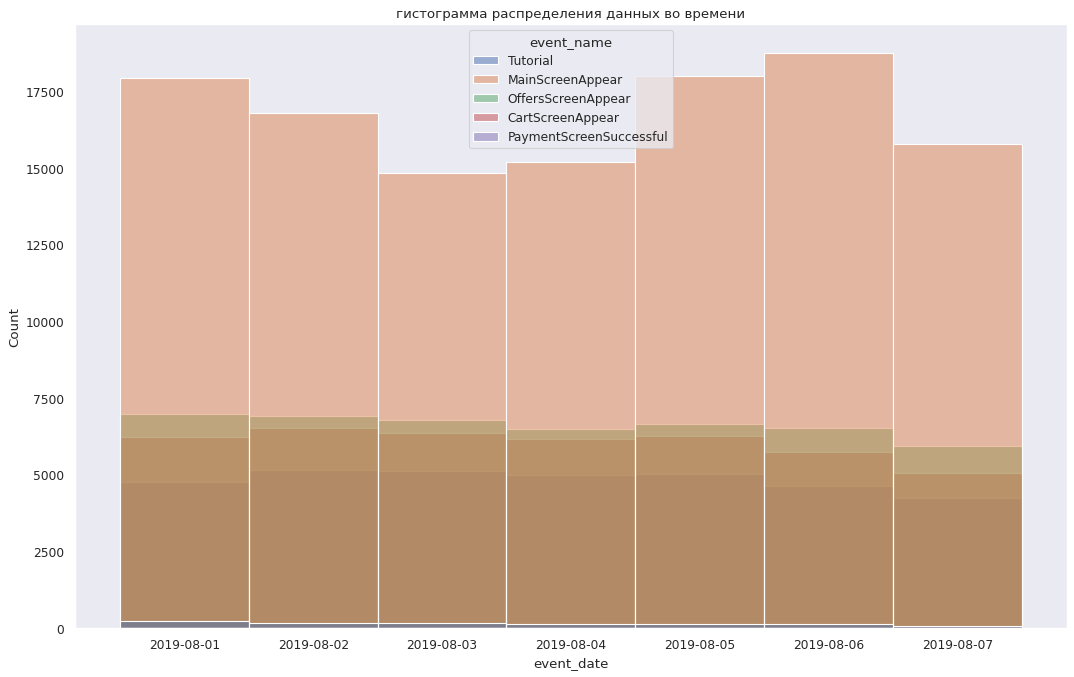

In [ ]:
#Построение гистограммы
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.set() 
sns.histplot(data=df, x="event_date", binwidth=0.05, hue="event_name")
plt.title('гистограмма распределения данных во времени')
plt.grid([])
plt.show()

Проверим сколько пользователей мы потеряли

In [ ]:
#расчет процента потерянных пользователей
uniq_user_after = df['user_id'].nunique()
print(f'Мы потеряли - {round(((uniq_user-uniq_user_after)*100/uniq_user),2)}% пользователей ')


Мы потеряли - 0.23% пользователей 


А так же посмотрим, на наполнение каждой группы, нет ли сильных перевесов по количеству пользователей

In [ ]:
#вывод уникальных пользователей в каждой группе теста
df.groupby('exp_id')['user_id'].nunique()

exp_id
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

Итак, для дальнейшего анализа мы оставили данные с *01.08 19 до 07.08.19.* Данные, что были до этого периода мы убрали из дальнейшего анализа, таким образом мы потеряли *0,23%* пользователей и *1.16%* действий. После всех действий, наши тестовые группы имеют примерно одинаковое количество уникальных юзеров. Значительных перевесов нет.

## Воронка событий

Как мы помним, событий у нас всего 5. Посмотрим Сколько совершил их каждый пользователь.

In [ ]:
#таблица с подсчетом количества пользователей в каждом событии
count_user  = (
    df.groupby(
    'event_name').agg({'user_id': 'nunique'})
    .reset_index().sort_values(by = 'user_id',ascending=False).reset_index()
)
#Удаление индекса
del count_user['index']
#расчет процента на каждом шаге от общего количества
count_user['per_for_all'] = (count_user['user_id']/df['user_id'].nunique())*100

#расчет процента каждого шага, от предыдущего шага
count_user = count_user.assign(per_for_step=count_user['user_id'].div(count_user['user_id'].shift()).mul(100))
count_user

,event_name,user_id,per_for_all,per_for_step
0,MainScreenAppear,7419,98.5,NaN
1,OffersScreenAppear,4593,61.0,61.9
2,CartScreenAppear,3734,49.6,81.3
3,PaymentScreenSuccessful,3539,47.0,94.8
4,Tutorial,840,11.1,23.7


На первом месте у нас `MainScreenAppear`, что логично, т.к. это главная страница.
<br> Хотелось бы обратить внимание на **Tutorial**. Т.к. переход на страницу руководства или инструкции для нас в данном анализе не представляет существенного интереса, а так же не совсем вписывается в цепочку нашего раследования, исключим эти данные при формировании *Воронки*

In [ ]:
#Исключение строки с данными о Tutorial
count_user = count_user[count_user['event_name'] != 'Tutorial']

count_user

,event_name,user_id,per_for_all,per_for_step
0,MainScreenAppear,7419,98.5,NaN
1,OffersScreenAppear,4593,61.0,61.9
2,CartScreenAppear,3734,49.6,81.3
3,PaymentScreenSuccessful,3539,47.0,94.8


Построим график.

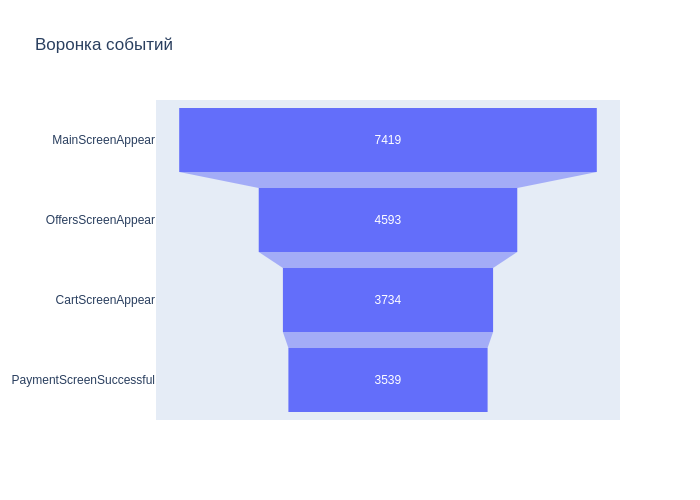

In [ ]:
#графическое построение воронки
fig = go.Figure(
    go.Funnel(
        y=count_user['event_name'],
        x=count_user['user_id'],
    )
)
fig.update_layout(title="Воронка событий")
fig.show() 

Расмотрим *Воронку* с разбивкой на группы.

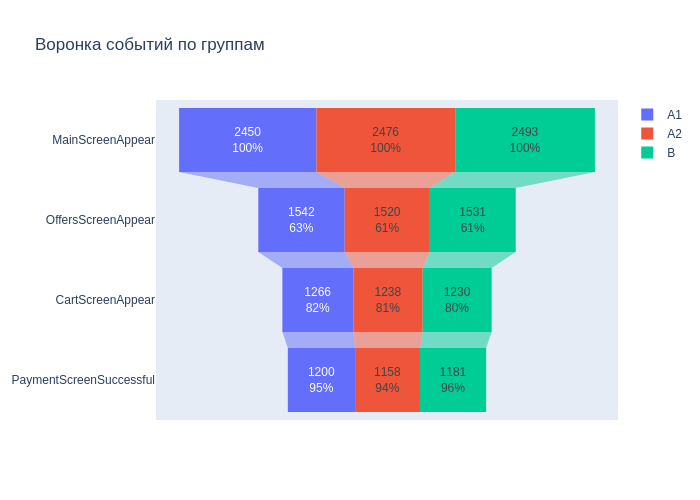

In [ ]:
#таблица для группы А1
count_user_A1 = df[df['exp_id'] =='A1']
count_user_A1 = (
    count_user_A1.groupby(
    'event_name').agg({'user_id': 'nunique'}).reset_index()
    .sort_values(by = 'user_id' ,ascending=False).reset_index()
)
del count_user_A1['index']
count_user_A1['per_for_first_step'] = (count_user_A1['user_id']/count_user_A1['user_id'].sum())*100

count_user_A1 = count_user_A1.assign(change=count_user_A1['user_id'].div(count_user_A1['user_id'].shift()).mul(100))
count_user_A1 = count_user_A1[count_user_A1['event_name'] != 'Tutorial']

#таблица для группы А2
count_user_A2 = df[df['exp_id'] =='A2']
count_user_A2 = (
    count_user_A2.groupby(
    'event_name').agg({'user_id': 'nunique'}).reset_index()
    .sort_values(by = 'user_id' ,ascending=False).reset_index()
)
del count_user_A2['index']
count_user_A2['per_for_first_step'] = (count_user_A2['user_id']/count_user_A2['user_id'].sum())*100

count_user_A2 = count_user_A2.assign(change=count_user_A2['user_id'].div(count_user_A2['user_id'].shift()).mul(100))
count_user_A2 = count_user_A2[count_user_A2['event_name'] != 'Tutorial']

#таблица для группы B
count_user_B = df[df['exp_id'] =='B']
count_user_B = (
    count_user_B.groupby(
    'event_name').agg({'user_id': 'nunique'}).reset_index()
    .sort_values(by = 'user_id' ,ascending=False).reset_index()
)
del count_user_B['index']
count_user_B['per_for_first_step'] = (count_user_B['user_id']/count_user_B['user_id'].sum())*100

count_user_B = count_user_B.assign(change=count_user_B['user_id'].div(count_user_B['user_id'].shift()).mul(100))
count_user_B = count_user_B[count_user_B['event_name'] != 'Tutorial']

#график построение
fig = go.Figure()
# группа А1
fig.add_trace(go.Funnel(
    name = 'A1',
    y = count_user_A1['event_name'],
    x = count_user_A1['user_id'],
    textinfo = "value+percent previous"))
# группа А2
fig.add_trace(go.Funnel(
    name = 'A2',
    orientation = "h",
    y = count_user_A2['event_name'],
    x = count_user_A2['user_id'],
    textposition = "inside",
    textinfo = "value+percent previous"))
# группа В
fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = count_user_B['event_name'],
    x = count_user_B['user_id'],
    textposition = "inside",
    textinfo = "value+percent previous"))
fig.update_layout(title="Воронка событий по группам")
fig.show()

Как и в количестве действий, наибольший процент пользователей теряется в моменте переход на *Страницу с товарами*, только 61-63% доходят до этой страницы.
<br>
<br>После построения *Воронок* мы выяснили, что наибольший процент пользователей теряется при переходе на *Страницу с товарами*. Т.е. большая часть пользователей даже не ознакомилась с нашим ассортиментом. 
<br>Необходимо выяснить  в чем может быть проблема. Возможно, из-за того, что большинство пользователей принебрегаютс *Страницей с инструкцией*, а дизайн перехода на *Страницу с товарами* не очень дружелюбен, пользователи теряются. 

## Изучение результатов эксперимента

Построим таблицу с количеством пользователей в каждой группе, а так же создадим строку с суммой пользователей в группах **A1** и **А2**

In [ ]:
#создание таблицы с  количеством пользователей в группах
users_test = df.groupby('exp_id')['user_id'].nunique()
users_test['A1+A2'] = users_test['A1']+users_test['A2']
users_test

exp_id
A1       2484
A2       2513
B        2537
A1+A2    4997
Name: user_id, dtype: int64

### Статистическая значимость различий в конверсии между группами  

Приступим к самому тестированию.
<br> Перед написанием функции, создадим таблицу, из которой будем вызывать данные.

In [ ]:
#создаем новую таблицу из которой исключаем переходы на страницу с инструкцией Tutorial
groups = df[df['event_name'] != 'Tutorial'].pivot_table(index='event_name', values='user_id', columns='exp_id',aggfunc=lambda x: len(x.unique()))
#сортировка и сброс индексов
groups = groups.reset_index().sort_values(by='A1', ascending=False).reset_index(drop=True)
#добавление новых столбцов
groups['A1+A2'] = groups['A1']+groups['A2']
groups['A1+A2+B'] = groups['A1+A2'] + groups['B']

groups

exp_id,event_name,A1,A2,B,A1+A2,A1+A2+B
0,MainScreenAppear,2450,2476,2493,4926,7419
1,OffersScreenAppear,1542,1520,1531,3062,4593
2,CartScreenAppear,1266,1238,1230,2504,3734
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539


Напишем функцию для выаолнения **z_test**-а

In [ ]:
#написание функции
def z_test(gr_1, gr_2, alpha):
    for i in groups.index:
        p1 = groups[gr_1][i] / users_test[gr_1]
        # пропорция успехов во второй группе:
        p2 = groups[gr_2][i] / users_test[gr_2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((groups[gr_1][i] + groups[gr_2][i]) / 
                      (users_test[gr_1] + users_test[gr_2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_test[gr_1] + 1/users_test[gr_2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(groups['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        


Первыми проверим группы **A1** и **A2**. 
<br>Сформулируем первые гипотезы:
<br>
<br>*H₀*: Статистически значимых различий в доли уникальных посетителей, побывавших на этапе воронки **A1** и **A2** нет.
<br>*H₁*: Различия в долях уникальных посетителей, побывавших на этапе воронки **A1** и **A2** статистически значимы.

In [ ]:
#вызов функции
z_test("A1", "A2", 0.01)

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Группы **A1** и **В**.
<br>Сформулируем первые гипотезы:
<br>
<br>*H₀*: Статистически значимых различий в доли уникальных посетителей, побывавших на этапе воронки **A1** и **B** нет.
<br>*H₁*: Различия в долях уникальных посетителей, побывавших на этапе воронки **A1** и **B** статистически значимы.

In [ ]:
#вызов функции
z_test("A1", "B", 0.01)

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Группы **A2** и **В**.
<br>Сформулируем первые гипотезы:
<br>
<br>*H₀*: Статистически значимых различий в доли уникальных посетителей, побывавших на этапе воронки **A2** и **B** нет.
<br>*H₁*: Различия в долях уникальных посетителей, побывавших на этапе воронки **A2** и **B** статистически значимы.

In [ ]:
#вызов функции
z_test("A2", "B", 0.01)

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



И последними протестируем сумму групп **A1 + А2** и **В**.
<br>Сформулируем первые гипотезы:
<br>
<br>*H₀*: Статистически значимых различий в доли уникальных посетителей, побывавших на этапе воронки **A1+A2** и **B** нет.
<br>*H₁*: Различия в долях уникальных посетителей, побывавших на этапе воронки **A1+A2** и **B** статистически значимы.

In [ ]:
#вызов функции
z_test("A1+A2", "B", 0.01)

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



*Значимой разницы* между группами ни разу *выявленно не было*.


Для каждой пары групп мы провели 4 теста. Таким образом мы провели всего 16 тестов.<br> При проверки наших гипотез мы рискуем получить ошибку первого рода( т.е. зафиксировать разницу между группами, когда её на самом деле нет). Мы ограничили вероятность такого события статистическим уровнем значимости: α - 0,01. После проведения теста, ни одна из гипотез не была отвергнута, разницы в долях уникальных пользователей оказались не значимы статистически.
<br>Т.к. в данном тесте мы имеем дело с множественной проверкой гипотез, итоги могут привести к увеличению ошибок первого рода. Можно было бы повторить тест с поправкой Бонферрони, т.е. разделить нашу α на количество тестов и применить полученную величину как уровень статистической значимости, но т.к. в нашем тестировании нет ни одной опровергнутой *H₀*, повторять тест с поправкой Бонферрони нет смысла.

## Вывод

- **1) Проверка данных**. При Проверке данных мы убрали из анализа часть предоставленного периода. Оставили данные с *01.08 19 до 07.08.19.* Убрали  *0,23%* пользователей и *1.16%* действий. Сделали это из-за того, что до 01.08.19 года данные оказались не полными и могли исказить дальнейший анализ. Наши тестовые группы получились примерно оинаковыми без значительных перевесов.
  

- **2) Воронка событий**. В порядке убывания действия выполняются таким образом:
<br>`MainScreenAppear` - Открытие главной страницы,
<br>`OffersScreenAppear`  - Открытие страницы с товарами,
<br>`CartScreenAppear` - Открытие страницы корзины,
<br>`PaymentScreenSuccessful` - Страница успешного платежа, 
<br>`Tutorial` - Руководство.
<br>Как выяснилось последнее действие не несет полезной нагрузки, и из иследования мы его исключили.
<br> Наибольший объем пользоватей (38%) теряется при переходе на *страницу с товарами*. Что является проблемой. Необходимо изучить **почему пользователи не доходят до этого этапа**.  

- **3)А1/А2/В - тесты**. В результате тестов разница между группами выявлена не была. Что позволяет нам сказать:  
 *Изменение шрифта в приложении не повлияло на поведение пользователей.*